# Ce notebook a été fait pour la révision au DS2

In [1]:
import matplotlib.pyplot as plt

import numpy as np

import torch
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn, optim
import torch.nn.functional as F

import torchvision
from torchvision import transforms

In [2]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    # Trasnformation: scale !
    trans = [transforms.ToTensor(), transforms.Normalize((0.5,),(0.5),)]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    
    mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)
    
    # Make trn, val, tst
    ind = list(range(len(mnist_train)))
    np.random.shuffle(ind)
    split = int(np.floor(.2 * len(mnist_train))) # taking 20% for val
    ind_trn = SubsetRandomSampler(ind[split:])
    ind_val = SubsetRandomSampler(ind[:split])
    
    trn_loader = data.DataLoader(mnist_train, sampler=ind_trn, batch_size=batch_size, num_workers=2)
    val_loader = data.DataLoader(mnist_train, sampler=ind_val, batch_size=batch_size, num_workers=2)
    tst_loader = data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=2)
    
    return trn_loader, val_loader, tst_loader                

In [3]:
def train_test(net, epochs, criterion, optimizer, data_iter):
    net.train()
    losses = []
    for e in range(1, epochs+1):
        running_loss = 0
        for i, data in enumerate(data_iter, 1):
            images, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
                        
            running_loss += loss.item()

            # print statistics
            if i % 200 == 0: # every 100
                losses += [loss.item()]
                print('e:%d, i:%d, loss:%.3f' % (e, i, running_loss/100))
                running_loss = 0
    return net, losses

def test(net, epochs, criterion, optimizer, data_iter):
    
    losses = []
    
    # We disable gradient computation which speeds up the computation
    # and reduces the memory usage
    with torch.no_grad():
        net.eval()
        for e in range(1, epochs+1):
            running_loss = 0
            for i, data in enumerate(data_iter, 1):
                images, labels = data

                # forward + backward + optimize
                outputs = net(images)

                loss = criterion(outputs, labels)

                running_loss += loss.item()

                # print statistics
                if i % 100 == 0: # every 100
                    losses += [loss.item()]
                    print('e:%d, i:%d, loss:%.3f' % (e, i, running_loss/100))
                    running_loss = 0
    return net, losses

In [4]:
def trn_crval_tst(net, epochs, criterion, optimizer, trn_iter, crv_iter, tst_iter):
    trn_loss, crv_loss, tst_loss = [], [], []

    # train
    for e in range(1, epochs+1):
            print(" Train: ", e, '/', epochs)
            _, losses = train_test(net, 1, criterion, optimizer, trn_iter)
            trn_loss += [ losses[-1] ]
            print(" CrssVal: ", e, '/', epochs)
            _, losses = test(net, 1, criterion, optimizer, crv_iter) # TEST HERE !
            crv_loss += [ losses[-1] ]
            print(" Test: ", e, '/', epochs)
            _, losses = test(net, 1, criterion, optimizer, tst_iter)
            tst_loss += [ losses[-1] ]
            
    return trn_loss, crv_loss, tst_loss

In [5]:
def trn_crval_tst_V2(net, epochs, criterion, optimizer, trn_iter, crv_iter, tst_iter):
    trn_loss, crv_loss, tst_loss = [], [], []

    # train
    for e in range(1, epochs+1):
            print(" Train: ", e, '/', epochs)
            _, losses = train_test(net, 1, criterion, optimizer, trn_iter)
            trn_loss += [ losses[-1] ]
            print(" CrssVal: ", e, '/', epochs)
            _, losses = train_test(net, 1, criterion, optimizer, crv_iter) # TRAIN HERE !
            crv_loss += [ losses[-1] ]
            print(" Test: ", e, '/', epochs)
            _, losses = test(net, 1, criterion, optimizer, tst_iter)
            tst_loss += [ losses[-1] ]
            
    return trn_loss, crv_loss, tst_loss

# Net0: Sequential
- Inputs:
    - size: 64pxl
- Hidden Layers:
    - L1: Dropout(ReLu(linear(64*64, 256), 0.2)
    - L2: Dropout(ReLu(linear(256, 128), 0.2)
    - L3: Dropout(ReLu(linear(128, 64), 0.2)
    - L4: LogSoftmax(linear(64, 10))
- Loss Function:
    - NLL
- Optimizer
    - SGD
        - learning_rate: 0.001
- Training Epochs:
    - 5

trn_loader:  1500
val_loader:  375
tst_loader:  313
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=4096, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=128, out_features=64, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.2, inplace=False)
  (10): Linear(in_features=64, out_features=10, bias=True)
  (11): LogSoftmax(dim=1)
)
Train ....
e:1, i:200, loss:4.582
e:1, i:400, loss:4.526
e:1, i:600, loss:4.448
e:1, i:800, loss:4.348
e:1, i:1000, loss:4.195
e:1, i:1200, loss:3.987
e:1, i:1400, loss:3.740
e:2, i:200, loss:3.258
e:2, i:400, loss:3.017
e:2, i:600, loss:2.746
e:2, i:800, loss:2.558
e:2, i:1000, loss:2.419
e:2, i:1200, loss:2.357
e:2, i:1400, loss:2.235
e:3, i:200, loss:2.128
e:3, i:400, loss:2.074
e:3, i:600, loss:1.994
e:3, i:800, loss:1.957
e:3, i:1000, loss:1.894
e:3, i:1200, loss:1.8

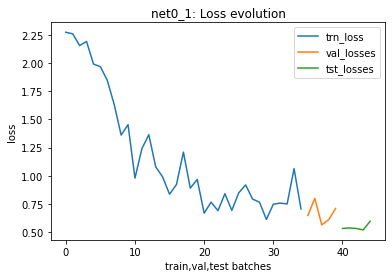

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=4096, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=128, out_features=64, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.2, inplace=False)
  (10): Linear(in_features=64, out_features=10, bias=True)
  (11): LogSoftmax(dim=1)
)
Train-Val-Test ....
 Train:  1 / 5
e:1, i:200, loss:4.562
e:1, i:400, loss:4.465
e:1, i:600, loss:4.355
e:1, i:800, loss:4.193
e:1, i:1000, loss:4.028
e:1, i:1200, loss:3.779
e:1, i:1400, loss:3.543
 CrssVal:  1 / 5
e:1, i:100, loss:1.583
e:1, i:200, loss:1.576
e:1, i:300, loss:1.570
 Test:  1 / 5
e:1, i:100, loss:1.581
e:1, i:200, loss:1.577
e:1, i:300, loss:1.568
 Train:  2 / 5
e:1, i:200, loss:3.171
e:1, i:400, loss:2.981
e:1, i:600, loss:2.791
e:1, i:800, loss:2.634
e:1, i:1000, loss:2.529
e:1, i:1200, loss:2.407
e:1, 

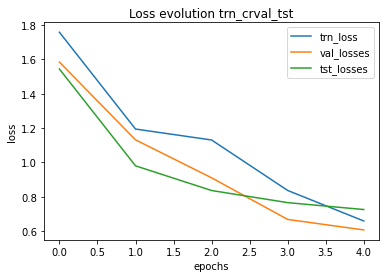

In [6]:
batch_size = 32
trn_loader, val_loader, tst_loader = load_data_fashion_mnist(batch_size, resize=64)
print('trn_loader: ', len(trn_loader))
print('val_loader: ', len(val_loader))
print('tst_loader: ', len(tst_loader))

net0_1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(64*64, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim = 1))
print(net0_1)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net0_1.parameters(), lr=0.001)
epochs = 5

print("Train ....")
net0_1, trn_losses = train_test(net0_1, epochs, criterion, optimizer, trn_loader)
print("Validation ....")
net0_1, val_losses = train_test(net0_1, epochs, criterion, optimizer, val_loader)
print("Test ....")
net0_1, tst_losses = train_test(net0_1, epochs, criterion, optimizer, tst_loader)

trn_intrvl = np.arange(len(trn_losses)) 
val_intrvl = np.arange(len(trn_losses), len(trn_losses)+len(val_losses))
tst_intrvl = np.arange(len(trn_losses)+len(val_losses), len(trn_losses)+len(val_losses)+len(tst_losses))

plt.title("net0_1: Loss evolution")
plt.plot(trn_intrvl, trn_losses, label='trn_loss')
plt.plot(val_intrvl, val_losses, label='val_losses')
plt.plot(tst_intrvl, tst_losses, label='tst_losses')
plt.xlabel('train,val,test batches') 
plt.ylabel('loss') 
plt.legend()
plt.show()

net0_2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(64*64, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim = 1))
print(net0_2)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net0_2.parameters(), lr=0.001)
epochs = 5

print("Train-Val-Test ....")
trn_losses, val_losses, tst_losses = trn_crval_tst(net0_2, epochs, criterion, optimizer, trn_loader, val_loader, tst_loader)

plt.title("Loss evolution trn_crval_tst")
plt.plot(trn_losses, label='trn_loss')
plt.plot(val_losses, label='val_losses')
plt.plot(tst_losses, label='tst_losses')
plt.xlabel('epochs') 
plt.ylabel('loss') 
plt.legend()
plt.show()

# Net1: Sequential
- Inputs:
    - size: 28pxl
- Hidden Layers:
    - L1: Dropout(ReLu(linear(28*28, 256), 0.2)
    - L2: Dropout(ReLu(linear(256, 128), 0.2)
    - L3: Dropout(ReLu(linear(128, 64), 0.2)
    - L4: LogSoftmax(linear(64, 10))
- Loss Function:
    - NLL
- Optimizer
    - SGD
        - learning_rate: 0.001
- Training Epochs:
    - 5

trn_loader:  1500
val_loader:  375
tst_loader:  313
Train ....
e:1, i:200, loss:4.608
e:1, i:400, loss:4.589
e:1, i:600, loss:4.579
e:1, i:800, loss:4.557
e:1, i:1000, loss:4.538
e:1, i:1200, loss:4.515
e:1, i:1400, loss:4.481
e:2, i:200, loss:4.421
e:2, i:400, loss:4.371
e:2, i:600, loss:4.316
e:2, i:800, loss:4.232
e:2, i:1000, loss:4.137
e:2, i:1200, loss:4.015
e:2, i:1400, loss:3.878
e:3, i:200, loss:3.645
e:3, i:400, loss:3.473
e:3, i:600, loss:3.337
e:3, i:800, loss:3.193
e:3, i:1000, loss:3.040
e:3, i:1200, loss:2.911
e:3, i:1400, loss:2.795
e:4, i:200, loss:2.682
e:4, i:400, loss:2.633
e:4, i:600, loss:2.533
e:4, i:800, loss:2.504
e:4, i:1000, loss:2.407
e:4, i:1200, loss:2.386
e:4, i:1400, loss:2.350
e:5, i:200, loss:2.294
e:5, i:400, loss:2.207
e:5, i:600, loss:2.189
e:5, i:800, loss:2.173
e:5, i:1000, loss:2.105
e:5, i:1200, loss:2.064
e:5, i:1400, loss:2.082
Validation ....
e:1, i:200, loss:1.994
e:2, i:200, loss:1.939
e:3, i:200, loss:1.909
e:4, i:200, loss:1.880
e:5, i:20

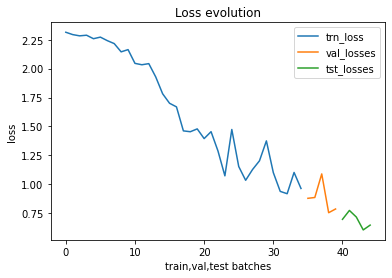

In [7]:
batch_size = 32
input_size = 28
trn_loader, val_loader, tst_loader = load_data_fashion_mnist(batch_size, resize=input_size)
print('trn_loader: ', len(trn_loader))
print('val_loader: ', len(val_loader))
print('tst_loader: ', len(tst_loader))

net0 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size*input_size, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim = 1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(net0.parameters(), lr=0.001)
epochs = 5

print("Train ....")
net0, trn_losses = train_test(net0, epochs, criterion, optimizer, trn_loader)
print("Validation ....")
net0, val_losses = train_test(net0, epochs, criterion, optimizer, val_loader)
print("Test ....")
net0, tst_losses = train_test(net0, epochs, criterion, optimizer, tst_loader)

trn_intrvl = np.arange(len(trn_losses)) 
val_intrvl = np.arange(len(trn_losses), len(trn_losses)+len(val_losses))
tst_intrvl = np.arange(len(trn_losses)+len(val_losses), len(trn_losses)+len(val_losses)+len(tst_losses))

plt.title("Loss evolution")
plt.plot(trn_intrvl, trn_losses, label='trn_loss')
plt.plot(val_intrvl, val_losses, label='val_losses')
plt.plot(tst_intrvl, tst_losses, label='tst_losses')
plt.xlabel('train,val,test batches') 
plt.ylabel('loss') 
plt.legend()
plt.show()

# Net2: Sequential
- Inputs:
    - size: 64pxl
- Hidden Layers:
    - L1: Dropout(ReLu(linear(64*64, 256), 0.2)
    - L2: Dropout(ReLu(linear(256, 128), 0.2)
    - L3: Dropout(ReLu(linear(128, 64), 0.2)
    - L4: LogSoftmax(linear(64, 10))
- Loss Function:
    - NLL
- Optimizer
    - Adam
        - learning_rate: 0.001
- Training Epochs:
    - 5

trn_loader:  1500
val_loader:  375
tst_loader:  313
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=4096, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=128, out_features=64, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.2, inplace=False)
  (10): Linear(in_features=64, out_features=10, bias=True)
  (11): LogSoftmax(dim=1)
)
Train ....
e:1, i:200, loss:1.912
e:1, i:400, loss:1.344
e:1, i:600, loss:1.214
e:1, i:800, loss:1.173
e:1, i:1000, loss:1.156
e:1, i:1200, loss:1.121
e:1, i:1400, loss:1.092
e:2, i:200, loss:1.025
e:2, i:400, loss:1.038
e:2, i:600, loss:1.012
e:2, i:800, loss:0.962
e:2, i:1000, loss:0.949
e:2, i:1200, loss:0.991
e:2, i:1400, loss:0.935
e:3, i:200, loss:0.895
e:3, i:400, loss:0.908
e:3, i:600, loss:0.941
e:3, i:800, loss:0.884
e:3, i:1000, loss:0.920
e:3, i:1200, loss:0.8

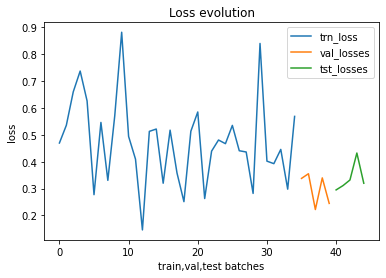

In [8]:
batch_size = 32
input_size = 64
trn_loader, val_loader, tst_loader = load_data_fashion_mnist(batch_size, resize=input_size)
print('trn_loader: ', len(trn_loader))
print('val_loader: ', len(val_loader))
print('tst_loader: ', len(tst_loader))

net2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size*input_size, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim = 1))
print(net2)

criterion = nn.NLLLoss()
optimizer = optim.Adam(net2.parameters(), lr=0.001)
epochs = 5

print("Train ....")
net0, trn_losses = train_test(net2, epochs, criterion, optimizer, trn_loader)
print("Validation ....")
net0, val_losses = train_test(net2, epochs, criterion, optimizer, val_loader)
print("Test ....")
net0, tst_losses = train_test(net2, epochs, criterion, optimizer, tst_loader)

trn_intrvl = np.arange(len(trn_losses)) 
val_intrvl = np.arange(len(trn_losses), len(trn_losses)+len(val_losses))
tst_intrvl = np.arange(len(trn_losses)+len(val_losses), len(trn_losses)+len(val_losses)+len(tst_losses))

plt.title("Loss evolution")
plt.plot(trn_intrvl, trn_losses, label='trn_loss')
plt.plot(val_intrvl, val_losses, label='val_losses')
plt.plot(tst_intrvl, tst_losses, label='tst_losses')
plt.xlabel('train,val,test batches') 
plt.ylabel('loss') 
plt.legend()
plt.show()

# Net3: Sequential
- Inputs:
    - size: 64pxl
- Hidden Layers:
    - L1: ReLu(linear(64*64, 256)
    - L2: ReLu(linear(256, 128)
    - L3: ReLu(linear(128, 64)
    - L4: LogSoftmax(linear(64, 10))
- Loss Function:
    - NLL
- Optimizer
    - ADAM
        - learning_rate: 0.001
- Training Epochs:
    - 5

trn_loader:  1500
val_loader:  375
tst_loader:  313
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=4096, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=64, bias=True)
  (6): ReLU()
  (7): Linear(in_features=64, out_features=10, bias=True)
  (8): LogSoftmax(dim=1)
)
Train ....
e:1, i:200, loss:1.538
e:1, i:400, loss:1.153
e:1, i:600, loss:1.052
e:1, i:800, loss:0.951
e:1, i:1000, loss:0.954
e:1, i:1200, loss:0.922
e:1, i:1400, loss:0.929
e:2, i:200, loss:0.898
e:2, i:400, loss:0.846
e:2, i:600, loss:0.844
e:2, i:800, loss:0.784
e:2, i:1000, loss:0.791
e:2, i:1200, loss:0.818
e:2, i:1400, loss:0.790
e:3, i:200, loss:0.750
e:3, i:400, loss:0.747
e:3, i:600, loss:0.730
e:3, i:800, loss:0.757
e:3, i:1000, loss:0.753
e:3, i:1200, loss:0.715
e:3, i:1400, loss:0.716
e:4, i:200, loss:0.692
e:4, i:400, loss:0.694
e:4, i:600, loss:0.674
e:4, i:800, loss:

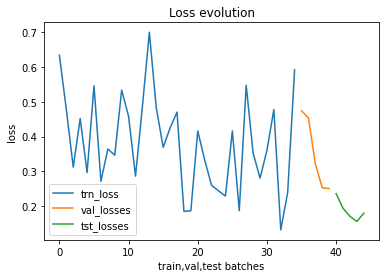

In [10]:
batch_size = 32
input_size = 64
trn_loader, val_loader, tst_loader = load_data_fashion_mnist(batch_size, resize=input_size)
print('trn_loader: ', len(trn_loader))
print('val_loader: ', len(val_loader))
print('tst_loader: ', len(tst_loader))

net3 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size*input_size, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim = 1))
print(net3)

criterion = nn.NLLLoss()
optimizer = optim.Adam(net3.parameters(), lr=0.001)
epochs = 5

print("Train ....")
net0, trn_losses = train_test(net3, epochs, criterion, optimizer, trn_loader)
print("Validation ....")
net0, val_losses = train_test(net3, epochs, criterion, optimizer, val_loader)
print("Test ....")
net0, tst_losses = train_test(net3, epochs, criterion, optimizer, tst_loader)

trn_intrvl = np.arange(len(trn_losses)) 
val_intrvl = np.arange(len(trn_losses), len(trn_losses)+len(val_losses))
tst_intrvl = np.arange(len(trn_losses)+len(val_losses), len(trn_losses)+len(val_losses)+len(tst_losses))

plt.title("Loss evolution")
plt.plot(trn_intrvl, trn_losses, label='trn_loss')
plt.plot(val_intrvl, val_losses, label='val_losses')
plt.plot(tst_intrvl, tst_losses, label='tst_losses')
plt.xlabel('train,val,test batches') 
plt.ylabel('loss') 
plt.legend()
plt.show()

# Net4: Sequential
- Inputs:
    - size: 64pxl
- Hidden Layers:
    - L1: ReLu(linear(64*64, 256)
    - L2: ReLu(linear(256, 128)
    - L3: ReLu(linear(128, 64)
    - L4: LogSoftmax(linear(64, 10))
- Loss Function:
    - NLL
- Optimizer
    - SGD
        - learning_rate: 0.001
- Training Epochs:
    - 5

trn_loader:  1500
val_loader:  375
tst_loader:  313
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=4096, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=64, bias=True)
  (6): ReLU()
  (7): Linear(in_features=64, out_features=10, bias=True)
  (8): LogSoftmax(dim=1)
)
Train ....
e:1, i:200, loss:4.591
e:1, i:400, loss:4.517
e:1, i:600, loss:4.434
e:1, i:800, loss:4.308
e:1, i:1000, loss:4.115
e:1, i:1200, loss:3.839
e:1, i:1400, loss:3.478
e:2, i:200, loss:2.900
e:2, i:400, loss:2.624
e:2, i:600, loss:2.369
e:2, i:800, loss:2.192
e:2, i:1000, loss:2.051
e:2, i:1200, loss:1.970
e:2, i:1400, loss:1.877
e:3, i:200, loss:1.736
e:3, i:400, loss:1.682
e:3, i:600, loss:1.636
e:3, i:800, loss:1.586
e:3, i:1000, loss:1.530
e:3, i:1200, loss:1.511
e:3, i:1400, loss:1.481
e:4, i:200, loss:1.432
e:4, i:400, loss:1.394
e:4, i:600, loss:1.396
e:4, i:800, loss:

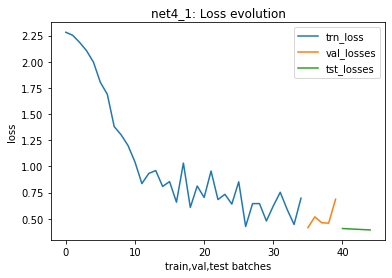

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=4096, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=64, bias=True)
  (6): ReLU()
  (7): Linear(in_features=64, out_features=10, bias=True)
  (8): LogSoftmax(dim=1)
)
net4_2: trn_crval_tst
 Train:  1 / 5
e:1, i:200, loss:4.562
e:1, i:400, loss:4.465
e:1, i:600, loss:4.351
e:1, i:800, loss:4.188
e:1, i:1000, loss:3.953
e:1, i:1200, loss:3.645
e:1, i:1400, loss:3.287
 CrssVal:  1 / 5
e:1, i:100, loss:1.480
e:1, i:200, loss:1.484
e:1, i:300, loss:1.485
 Test:  1 / 5
e:1, i:100, loss:1.492
e:1, i:200, loss:1.482
e:1, i:300, loss:1.480
 Train:  2 / 5
e:1, i:200, loss:2.822
e:1, i:400, loss:2.539
e:1, i:600, loss:2.308
e:1, i:800, loss:2.167
e:1, i:1000, loss:2.005
e:1, i:1200, loss:1.885
e:1, i:1400, loss:1.834
 CrssVal:  2 / 5
e:1, i:100, loss:0.870
e:1, i:200, loss:0.884
e:1, i:300, loss:0.870
 Test:

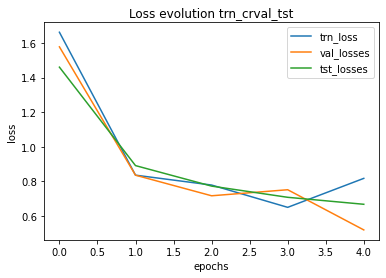

In [12]:
batch_size = 32
input_size = 64
trn_loader, val_loader, tst_loader = load_data_fashion_mnist(batch_size, resize=input_size)
print('trn_loader: ', len(trn_loader))
print('val_loader: ', len(val_loader))
print('tst_loader: ', len(tst_loader))

net4_1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size*input_size, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim = 1))
print(net4_1)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net4_1.parameters(), lr=0.001)
epochs = 5

print("Train ....")
net0, trn_losses = train_test(net4_1, epochs, criterion, optimizer, trn_loader)
print("Validation ....")
net0, val_losses = train_test(net4_1, epochs, criterion, optimizer, val_loader)
print("Test ....")
net0, tst_losses = train_test(net4_1, epochs, criterion, optimizer, tst_loader)

trn_intrvl = np.arange(len(trn_losses)) 
val_intrvl = np.arange(len(trn_losses), len(trn_losses)+len(val_losses))
tst_intrvl = np.arange(len(trn_losses)+len(val_losses), len(trn_losses)+len(val_losses)+len(tst_losses))

plt.title("net4_1: Loss evolution")
plt.plot(trn_intrvl, trn_losses, label='trn_loss')
plt.plot(val_intrvl, val_losses, label='val_losses')
plt.plot(tst_intrvl, tst_losses, label='tst_losses')
plt.xlabel('train,val,test batches') 
plt.ylabel('loss') 
plt.legend()
plt.show()


net4_2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size*input_size, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim = 1))
print(net4_2)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net4_2.parameters(), lr=0.001)
epochs = 5

print("net4_2: trn_crval_tst")
trn_losses, val_losses, tst_losses = trn_crval_tst(net4_2, epochs, criterion, optimizer, trn_loader, val_loader, tst_loader)
plt.title("Loss evolution trn_crval_tst")
plt.plot(trn_losses, label='trn_loss')
plt.plot(val_losses, label='val_losses')
plt.plot(tst_losses, label='tst_losses')
plt.xlabel('epochs') 
plt.ylabel('loss') 
plt.legend()
plt.show()

# Net1: size:28*28, conv:2 *2

trn_loader:  1500
val_loader:  375
tst_loader:  313
Net5(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(3, 3))
  (fc1): Linear(in_features=128, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)
conv1.size:  torch.Size([2, 1, 5, 5])
fc1.size:  torch.Size([84, 128])
net5: trn_crval_tst
 Train:  1 / 5


<ipython-input-41-2960a6d0f653>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.log_softmax(self.fc2(x)) # P(y|x)


e:1, i:200, loss:4.562
e:1, i:400, loss:4.526
e:1, i:600, loss:4.460
e:1, i:800, loss:4.387
e:1, i:1000, loss:4.239
e:1, i:1200, loss:4.042
e:1, i:1400, loss:3.753
 CrssVal:  1 / 5
e:1, i:100, loss:1.693
e:1, i:200, loss:1.686
e:1, i:300, loss:1.675
 Test:  1 / 5
e:1, i:100, loss:1.700
e:1, i:200, loss:1.688
e:1, i:300, loss:1.687
 Train:  2 / 5
e:1, i:200, loss:3.167
e:1, i:400, loss:2.780
e:1, i:600, loss:2.496
e:1, i:800, loss:2.239
e:1, i:1000, loss:2.057
e:1, i:1200, loss:1.915
e:1, i:1400, loss:1.858
 CrssVal:  2 / 5
e:1, i:100, loss:0.895
e:1, i:200, loss:0.888
e:1, i:300, loss:0.894
 Test:  2 / 5
e:1, i:100, loss:0.908
e:1, i:200, loss:0.901
e:1, i:300, loss:0.898
 Train:  3 / 5
e:1, i:200, loss:1.731
e:1, i:400, loss:1.686
e:1, i:600, loss:1.653
e:1, i:800, loss:1.604
e:1, i:1000, loss:1.603
e:1, i:1200, loss:1.544
e:1, i:1400, loss:1.548
 CrssVal:  3 / 5
e:1, i:100, loss:0.777
e:1, i:200, loss:0.756
e:1, i:300, loss:0.749
 Test:  3 / 5
e:1, i:100, loss:0.776
e:1, i:200, loss:

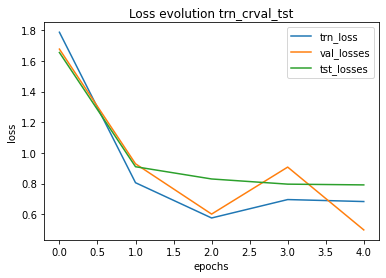

In [41]:
batch_size = 32
input_size = 28
trn_loader, val_loader, tst_loader = load_data_fashion_mnist(batch_size, resize=input_size)
print('trn_loader: ', len(trn_loader))
print('val_loader: ', len(val_loader))
print('tst_loader: ', len(tst_loader))
 

class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        # 1 canal d'entrée, 2 canaux de sortie, convolution par un kernel 5x5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=5, stride=3)
        # les parametres du percetron multi-couche: y = Wx + b
        self.fc1 = nn.Linear(2*8*8, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling sur une fenêtre de 3x3 (par défaut stride=taille de la fenêtre)
        x =F.relu(self.conv1(x))
        x = torch.flatten(x, start_dim=1) # transforme le tenseur en vecteur (dim 0 est celle du batch)
        # Perceptron
        x = F.relu(self.fc1(x))
        x = nn.functional.log_softmax(self.fc2(x)) # P(y|x)
        return x

# Do it
net5 = Net5()
print(net5)
print('conv1.size: ', net5.conv1.weight.size())
print('fc1.size: ', net5.fc1.weight.size())


criterion = nn.NLLLoss()
optimizer = optim.SGD(net5.parameters(), lr=0.001)
epochs = 5

print("net5: trn_crval_tst")
trn_losses, val_losses, tst_losses = trn_crval_tst(net5, epochs, criterion, optimizer, trn_loader, val_loader, tst_loader)
plt.title("Loss evolution trn_crval_tst")
plt.plot(trn_losses, label='trn_loss')
plt.plot(val_losses, label='val_losses')
plt.plot(tst_losses, label='tst_losses')
plt.xlabel('epochs') 
plt.ylabel('loss') 
plt.legend()
plt.show()

trn_loader:  1500
val_loader:  375
tst_loader:  313
Net6(
  (conv1): Conv2d(1, 5, kernel_size=(5, 5), stride=(3, 3))
  (fc1): Linear(in_features=320, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)
conv1.size:  torch.Size([5, 1, 5, 5])
fc1.size:  torch.Size([84, 320])
net6: trn_crval_tst
 Train:  1 / 5


<ipython-input-44-3815c3cd31c5>:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.log_softmax(self.fc2(x)) # P(y|x)


e:1, i:200, loss:4.611
e:1, i:400, loss:4.585
e:1, i:600, loss:4.553
e:1, i:800, loss:4.501
e:1, i:1000, loss:4.423
e:1, i:1200, loss:4.309
e:1, i:1400, loss:4.118
 CrssVal:  1 / 5
e:1, i:100, loss:1.941
e:1, i:200, loss:1.934
e:1, i:300, loss:1.932
 Test:  1 / 5
e:1, i:100, loss:1.936
e:1, i:200, loss:1.930
e:1, i:300, loss:1.925
 Train:  2 / 5
e:1, i:200, loss:3.692
e:1, i:400, loss:3.307
e:1, i:600, loss:2.944
e:1, i:800, loss:2.590
e:1, i:1000, loss:2.367
e:1, i:1200, loss:2.132
e:1, i:1400, loss:2.034
 CrssVal:  2 / 5
e:1, i:100, loss:0.972
e:1, i:200, loss:0.947
e:1, i:300, loss:0.958
 Test:  2 / 5
e:1, i:100, loss:0.970
e:1, i:200, loss:0.963
e:1, i:300, loss:0.954
 Train:  3 / 5
e:1, i:200, loss:1.860
e:1, i:400, loss:1.777
e:1, i:600, loss:1.742
e:1, i:800, loss:1.671
e:1, i:1000, loss:1.636
e:1, i:1200, loss:1.618
e:1, i:1400, loss:1.591
 CrssVal:  3 / 5
e:1, i:100, loss:0.776
e:1, i:200, loss:0.793
e:1, i:300, loss:0.797
 Test:  3 / 5
e:1, i:100, loss:0.797
e:1, i:200, loss:

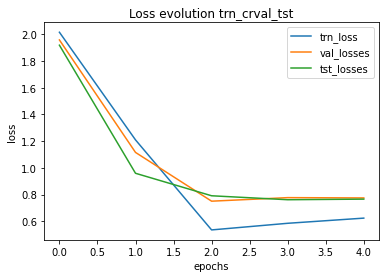

In [44]:
batch_size = 32
input_size = 28
trn_loader, val_loader, tst_loader = load_data_fashion_mnist(batch_size, resize=input_size)
print('trn_loader: ', len(trn_loader))
print('val_loader: ', len(val_loader))
print('tst_loader: ', len(tst_loader))
 

class Net6(nn.Module):
    def __init__(self):
        super(Net6, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=5, stride=3)
        #self.conv2 = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=5, stride=3)

        # les parametres du percetron multi-couche: y = Wx + b
        self.fc1 = nn.Linear(5*8*8, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        
        x =F.relu(self.conv1(x))
        x = torch.flatten(x, start_dim=1)
        
        # Perceptron
        x = F.relu(self.fc1(x))
        x = nn.functional.log_softmax(self.fc2(x)) # P(y|x)
        return x

# Do it
net6 = Net6()
print(net6)
print('conv1.size: ', net6.conv1.weight.size())
print('fc1.size: ', net6.fc1.weight.size())


criterion = nn.NLLLoss()
optimizer = optim.SGD(net6.parameters(), lr=0.001)
epochs = 5

print("net6: trn_crval_tst")
trn_losses, val_losses, tst_losses = trn_crval_tst(net6, epochs, criterion, optimizer, trn_loader, val_loader, tst_loader)
plt.title("Loss evolution trn_crval_tst")
plt.plot(trn_losses, label='trn_loss')
plt.plot(val_losses, label='val_losses')
plt.plot(tst_losses, label='tst_losses')
plt.xlabel('epochs') 
plt.ylabel('loss') 
plt.legend()
plt.show()

trn_loader:  1500
val_loader:  375
tst_loader:  313
Net7(
  (conv1): Conv2d(1, 5, kernel_size=(8, 8), stride=(4, 4))
  (fc1): Linear(in_features=1125, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)
net6: trn_crval_tst
 Train:  1 / 5


<ipython-input-57-c1d8b94f08ef>:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.log_softmax(self.fc2(x)) # P(y|x)


e:1, i:200, loss:4.565
e:1, i:400, loss:4.340
e:1, i:600, loss:3.681
e:1, i:800, loss:2.708
e:1, i:1000, loss:2.051
e:1, i:1200, loss:1.737
e:1, i:1400, loss:1.589
 CrssVal:  1 / 5
e:1, i:100, loss:0.739
e:1, i:200, loss:0.738
e:1, i:300, loss:0.742
 Test:  1 / 5
e:1, i:100, loss:0.765
e:1, i:200, loss:0.769
e:1, i:300, loss:0.754
 Train:  2 / 5
e:1, i:200, loss:1.490
e:1, i:400, loss:1.418
e:1, i:600, loss:1.382
e:1, i:800, loss:1.329
e:1, i:1000, loss:1.323
e:1, i:1200, loss:1.281
e:1, i:1400, loss:1.268
 CrssVal:  2 / 5
e:1, i:100, loss:0.618
e:1, i:200, loss:0.597
e:1, i:300, loss:0.609
 Test:  2 / 5
e:1, i:100, loss:0.636
e:1, i:200, loss:0.657
e:1, i:300, loss:0.632
 Train:  3 / 5
e:1, i:200, loss:1.260
e:1, i:400, loss:1.220
e:1, i:600, loss:1.170
e:1, i:800, loss:1.188
e:1, i:1000, loss:1.169
e:1, i:1200, loss:1.173
e:1, i:1400, loss:1.174
 CrssVal:  3 / 5
e:1, i:100, loss:0.560
e:1, i:200, loss:0.573
e:1, i:300, loss:0.556
 Test:  3 / 5
e:1, i:100, loss:0.586
e:1, i:200, loss:

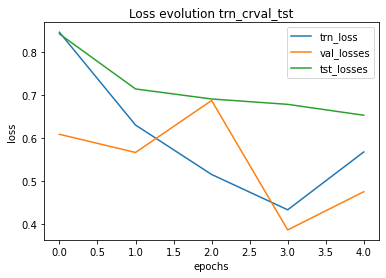

In [57]:
batch_size = 32
input_size = 64
trn_loader, val_loader, tst_loader = load_data_fashion_mnist(batch_size, resize=input_size)
print('trn_loader: ', len(trn_loader))
print('val_loader: ', len(val_loader))
print('tst_loader: ', len(tst_loader))
 

class Net7(nn.Module):
    def __init__(self):
        super(Net7, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=8, stride=4)

        # les parametres du percetron multi-couche: y = Wx + b
        self.fc1 = nn.Linear(5*15*15, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        
        x =F.relu(self.conv1(x))
        x = torch.flatten(x, start_dim=1)
        
        # Perceptron
        x = F.relu(self.fc1(x))
        x = nn.functional.log_softmax(self.fc2(x), dim=1) # P(y|x)
        return x

# Do it
net7 = Net7()
print(net7)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net7.parameters(), lr=0.001)
epochs = 5

print("net6: trn_crval_tst")
trn_losses, val_losses, tst_losses = trn_crval_tst(net7, epochs, criterion, optimizer, trn_loader, val_loader, tst_loader)
plt.title("Loss evolution trn_crval_tst")
plt.plot(trn_losses, label='trn_loss')
plt.plot(val_losses, label='val_losses')
plt.plot(tst_losses, label='tst_losses')
plt.xlabel('epochs') 
plt.ylabel('loss') 
plt.legend()
plt.show()

trn_loader:  1500
val_loader:  375
tst_loader:  313
Net8(
  (conv1): Conv2d(1, 5, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(5, 2, kernel_size=(3, 3), stride=(4, 4))
  (fc1): Linear(in_features=32, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)
net8: trn_crval_tst
 Train:  1 / 5
e:1, i:200, loss:4.615
e:1, i:400, loss:4.613
e:1, i:600, loss:4.613
e:1, i:800, loss:4.610
e:1, i:1000, loss:4.609
e:1, i:1200, loss:4.603
e:1, i:1400, loss:4.608
 CrssVal:  1 / 5
e:1, i:100, loss:2.301
e:1, i:200, loss:2.304
e:1, i:300, loss:2.304
 Test:  1 / 5
e:1, i:100, loss:2.304
e:1, i:200, loss:2.302
e:1, i:300, loss:2.302
 Train:  2 / 5
e:1, i:200, loss:4.605
e:1, i:400, loss:4.603
e:1, i:600, loss:4.601
e:1, i:800, loss:4.601
e:1, i:1000, loss:4.601
e:1, i:1200, loss:4.600
e:1, i:1400, loss:4.598
 CrssVal:  2 / 5
e:1, i:100, loss:2.300
e:1, i:200, loss:2.300
e:1, i:300, loss:2.297
 Test:  2 / 5
e:1, i:100, loss:2.299
e:1, i:200, loss:2.298
e:1, i:30

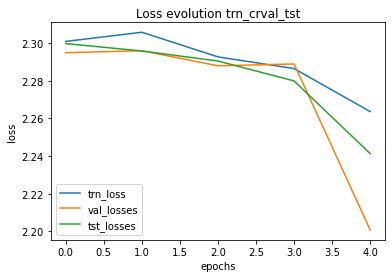

In [59]:
batch_size = 32
input_size = 64
trn_loader, val_loader, tst_loader = load_data_fashion_mnist(batch_size, resize=input_size)
print('trn_loader: ', len(trn_loader))
print('val_loader: ', len(val_loader))
print('tst_loader: ', len(tst_loader))
 

class Net8(nn.Module):
    def __init__(self):
        super(Net8, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=2, kernel_size=3, stride=4)

        # les parametres du percetron multi-couche: y = Wx + b
        self.fc1 = nn.Linear(2*4*4, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        x = torch.flatten(x, start_dim=1)
        
        # Perceptron
        x = F.relu(self.fc1(x))
        x = nn.functional.log_softmax(self.fc2(x), dim=1) # P(y|x)
        return x

# Do it
net8 = Net8()
print(net8)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net8.parameters(), lr=0.001)
epochs = 5

print("net8: trn_crval_tst")
trn_losses, val_losses, tst_losses = trn_crval_tst(net8, epochs, criterion, optimizer, trn_loader, val_loader, tst_loader)
plt.title("Loss evolution trn_crval_tst")
plt.plot(trn_losses, label='trn_loss')
plt.plot(val_losses, label='val_losses')
plt.plot(tst_losses, label='tst_losses')
plt.xlabel('epochs') 
plt.ylabel('loss') 
plt.legend()
plt.show()

In [65]:
batch_size = 32
input_size = 64
trn_loader, val_loader, tst_loader = load_data_fashion_mnist(batch_size, resize=input_size)
print('trn_loader: ', len(trn_loader))
print('val_loader: ', len(val_loader))
print('tst_loader: ', len(tst_loader))
 

class Net9(nn.Module):
    def __init__(self):
        super(Net9, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=2, kernel_size=3, stride=4)

        # les parametres du percetron multi-couche: y = Wx + b
        self.fc1 = nn.Linear(2*4*4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        x = torch.flatten(x, start_dim=1)
        
        # Perceptron
        x = F.relu(self.fc1(x))
        x = nn.functional.log_softmax(self.fc2(x), dim=1) # P(y|x)
        return x

# Do it
net9 = Net9()
print(net9)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net9.parameters(), lr=0.001)
epochs = 5

print("net9: trn_crval_tst")
trn_losses, val_losses, tst_losses = trn_crval_tst(net9, epochs, criterion, optimizer, trn_loader, val_loader, tst_loader)
plt.title("Loss evolution trn_crval_tst")
plt.plot(trn_losses, label='trn_loss')
plt.plot(val_losses, label='val_losses')
plt.plot(tst_losses, label='tst_losses')
plt.xlabel('epochs') 
plt.ylabel('loss') 
plt.legend()
plt.show()

trn_loader:  1500
val_loader:  375
tst_loader:  313
Net9(
  (conv1): Conv2d(1, 5, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(5, 2, kernel_size=(3, 3), stride=(4, 4))
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
net9: trn_crval_tst
 Train:  1 / 5
e:1, i:200, loss:4.604


Traceback (most recent call last):
  File "/opt/anaconda/envs/SD/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/opt/anaconda/envs/SD/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda/envs/SD/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda/envs/SD/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/opt/anaconda/envs/SD/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/opt/anaconda/envs/SD/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda/envs/SD/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(he

KeyboardInterrupt: 

trn_loader:  1500
val_loader:  375
tst_loader:  313
net11: trn_crval_tst
 Train:  1 / 5
e:1, i:200, loss:4.643
e:1, i:400, loss:4.610
e:1, i:600, loss:4.611
e:1, i:800, loss:4.609
e:1, i:1000, loss:4.606
e:1, i:1200, loss:4.606
e:1, i:1400, loss:4.606
 CrssVal:  1 / 5
e:1, i:100, loss:2.303
e:1, i:200, loss:2.303
e:1, i:300, loss:2.303
 Test:  1 / 5
e:1, i:100, loss:2.302
e:1, i:200, loss:2.303
e:1, i:300, loss:2.303
 Train:  2 / 5
e:1, i:200, loss:4.606
e:1, i:400, loss:4.605
e:1, i:600, loss:4.606
e:1, i:800, loss:4.606
e:1, i:1000, loss:4.606
e:1, i:1200, loss:4.605
e:1, i:1400, loss:4.606
 CrssVal:  2 / 5
e:1, i:100, loss:2.303
e:1, i:200, loss:2.303
e:1, i:300, loss:2.302
 Test:  2 / 5
e:1, i:100, loss:2.303
e:1, i:200, loss:2.303
e:1, i:300, loss:2.303
 Train:  3 / 5
e:1, i:200, loss:4.606
e:1, i:400, loss:4.606
e:1, i:600, loss:4.605
e:1, i:800, loss:4.606
e:1, i:1000, loss:4.606
e:1, i:1200, loss:4.605
e:1, i:1400, loss:4.606
 CrssVal:  3 / 5
e:1, i:100, loss:2.303
e:1, i:200, 

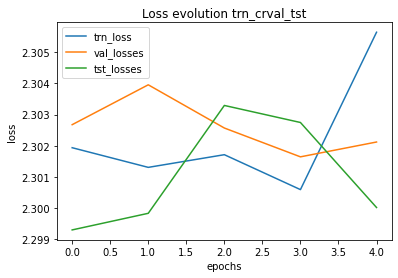

In [67]:
batch_size = 32
input_size = 28
trn_loader, val_loader, tst_loader = load_data_fashion_mnist(batch_size, resize=input_size)
print('trn_loader: ', len(trn_loader))
print('val_loader: ', len(val_loader))
print('tst_loader: ', len(tst_loader))

class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)

net11 = torch.nn.Sequential(
    #Reshape(), 
    nn.Conv2d(1, 6, kernel_size=5,padding=2), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(), nn.Linear(84, 10))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net11.parameters(), lr=0.001)
epochs = 5

print("net11: trn_crval_tst")
trn_losses, val_losses, tst_losses = trn_crval_tst(net11, epochs, criterion, optimizer, trn_loader, val_loader, tst_loader)
plt.title("Loss evolution trn_crval_tst")
plt.plot(trn_losses, label='trn_loss')
plt.plot(val_losses, label='val_losses')
plt.plot(tst_losses, label='tst_losses')
plt.xlabel('epochs') 
plt.ylabel('loss') 
plt.legend()
plt.show()